### Fruit and Vegetable Seasonality Chart

Data is availbale from the [BBC Good Food](https://www.bbcgoodfood.com/seasonal-calendar) website, but it is ordered alphabetically and difficult to read. Lets make it look nicer

In [1]:
from collections import defaultdict

import pandas as pd
import numpy as np
from scipy import ndimage as ndi

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

%matplotlib inline

In [2]:
# I've just copied the html for the tables from the website using the
# elements tab in google chrome developer tools
fruit, veg, meat, fish = pd.read_html('./bbcgoodfood_seasonality.html', index_col=0)
veg_seasonality = pd.concat([fruit, veg], axis=0)
veg_seasonality[veg_seasonality.isnull()] = 0
veg_seasonality[veg_seasonality == 'Coming in'] = 0.5
veg_seasonality[veg_seasonality == 'At its best'] = 1
veg_seasonality = veg_seasonality.astype('f')
veg_seasonality.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Apple,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
Apricot,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
Banana,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Blackberry,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0,1.0,1.0,0.0,0.0
Blackcurrants,0.0,0.0,0.0,0.0,0.5,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [3]:
def seasonality_start_ends(df):
    df = df.copy()
    df.insert(0, 'prevDec', df['Dec'])
    df.insert(len(df.columns), 'nextJan', df['Jan'])
    season_coming_in = ndi.binary_hit_or_miss(df, [[0, 1]])[:, 1:]
    df[df < 1] = 0
    season_start = ndi.binary_hit_or_miss(df, [[0, 1]])[:, 1:]
    season_end = ndi.binary_hit_or_miss(df, [[1, 0]])[:, 1:]
    seasons = np.asarray([np.argmax(season_coming_in, axis=1),
                          np.argmax(season_start, axis=1),
                          np.argmax(season_end, axis=1)]).T
    seasons = pd.DataFrame(seasons,
                           columns=['coming_in', 'start', 'end'],
                           index=df.index)
    seasons[df.all(1)] = np.nan
    return seasons

veg_season_idx = seasonality_start_ends(veg_seasonality).reset_index()
veg_season_idx = veg_season_idx.sort_values(
    by=['start', 'coming_in', 'end', 'index'],
    na_position='last')
veg_seasonality_ordered = veg_seasonality.iloc[veg_season_idx.index]
veg_seasonality_ordered.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Chicory,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lemon,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Orange,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rhubarb,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Cauliflower,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5


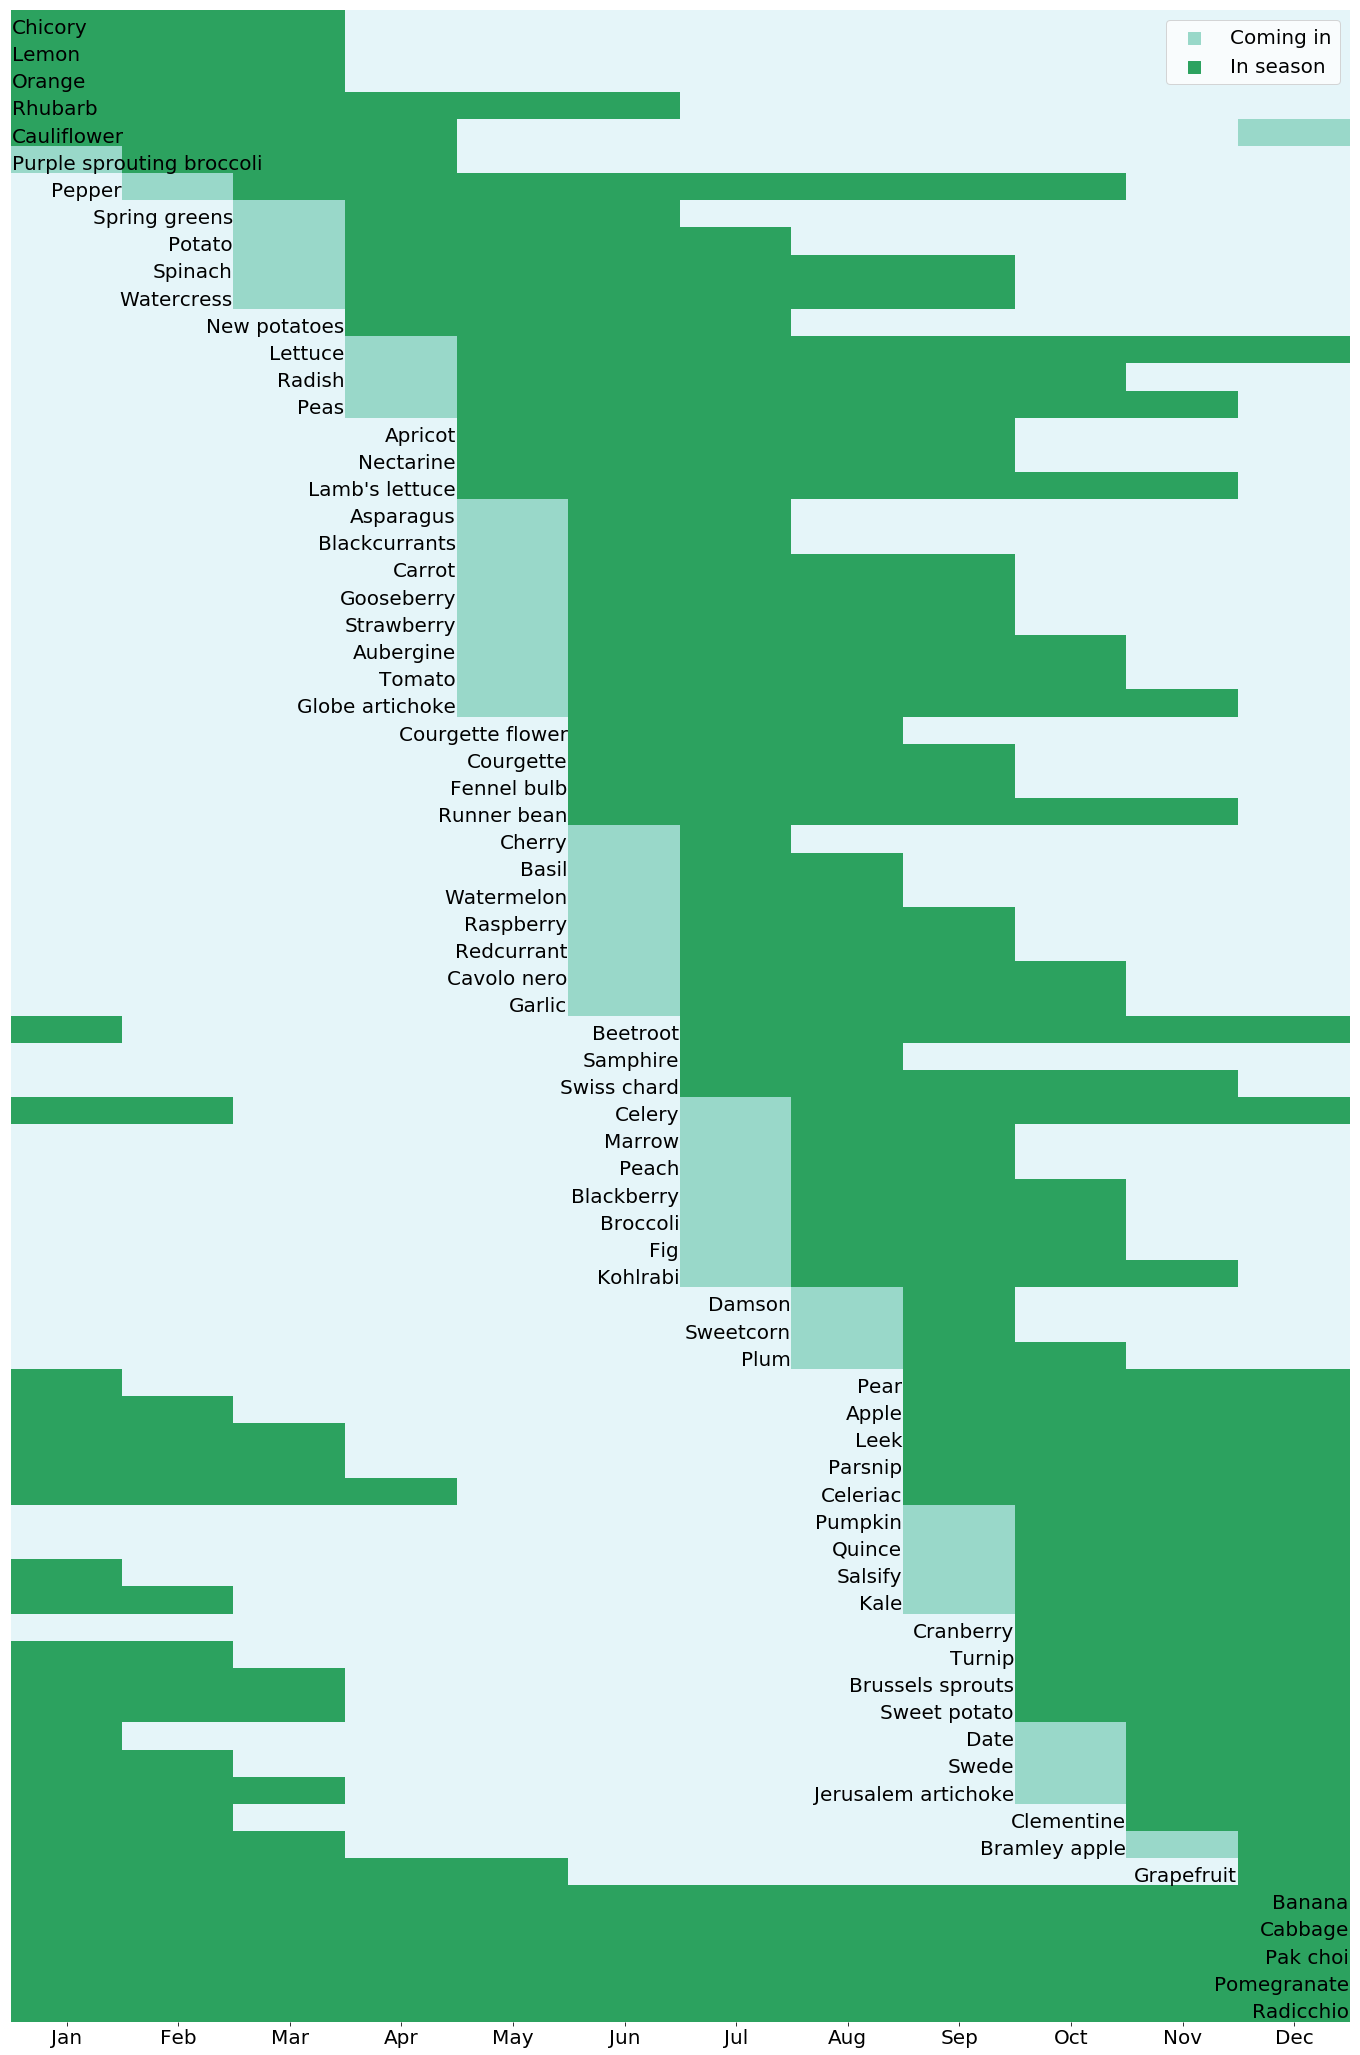

In [4]:
def plot_seasonality_chart(df, idx_df, colors, legend=True):
    cmap = ListedColormap(colors)
    fig, ax = plt.subplots(figsize=(df.shape[1] * 2, df.shape[0] * 0.5))
    sns.heatmap(df, cbar=False, ax=ax, cmap=cmap, yticklabels=False, )
    for y, name, coming_in, start, end in idx_df.reset_index(drop=True).itertuples():
        if not np.isnan(coming_in):
            x = min(coming_in, start)
        else:
            x = 12
        ha = 'right' if x else 'left'
        x += -0.01 if x else 0.01
        ax.annotate(s=name,
                    xy=(x, y + 1),
                    horizontalalignment=ha,
                    verticalalignment='bottom',
                    fontsize=20)
    plt.setp(ax.get_xticklabels(), size=20)
    if legend:
        for text, color in zip(['Coming in', 'In season'], colors[1:]):
            ax.scatter([], [], color=color, label=text, marker='s', s=150)
        plt.legend(loc=1, fontsize=20)
    return ax

colors = ['#e5f5f9', '#99d8c9', '#2ca25f']
ax = plot_seasonality_chart(veg_seasonality_ordered,
                            veg_season_idx,
                            colors,
                            legend=True)
plt.show()

## How bad are bananas:

there is also a fruit and veg seasonality chart in the back of the book "How bad are bananas" by Mike Berners-Lee. This was in the form of a plain text list of veg for each month. I scanned in the page and converted it to text using `tesseract-ocr`. We can clean and plot this data too:

In [5]:
# there are separate records for fruit and vegetables, we can join these together

monthly_records = defaultdict(str)

with open('./howbadarebananas_seasonality.txt') as f:
    record = ''
    month = None
    for line in f:
        line = line.strip().lower()
        try:
            month, veg = line.split(':')
            veg = veg.strip()
            record = ''
        except ValueError:
            veg = line
        monthly_records[month] += ' {}'.format(veg)

veg_seasonality_hbab = pd.Series(monthly_records).str.get_dummies(',')
veg_seasonality_hbab.columns = veg_seasonality_hbab.columns.str.strip()
veg_seasonality_hbab = veg_seasonality_hbab.iloc[:, 3:].copy().T
veg_seasonality_hbab.sort_index(inplace=True)

all_year_round = veg_seasonality_hbab.pop('all year round')
for col in veg_seasonality_hbab.columns:
    veg_seasonality_hbab[col] = veg_seasonality_hbab[col] | all_year_round

veg_seasonality_hbab = veg_seasonality_hbab[[
    'january', 'february', 'march', 'april', 'may',
    'june', 'july', 'august', 'september', 'october',
    'november', 'december'
]]
veg_seasonality_hbab.columns = veg_seasonality_hbab.columns.str[:3].str.capitalize()
veg_seasonality_hbab.index = veg_seasonality_hbab.index.str.capitalize()
veg_seasonality_hbab = veg_seasonality_hbab.groupby(veg_seasonality_hbab.index).max()
veg_seasonality_hbab.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Apples,1,1,1,1,1,1,1,1,1,1,1,1
Asparagus,0,0,0,1,1,1,0,0,0,0,0,0
Aubergine,0,0,0,0,0,1,1,1,1,0,0,0
Bananas,1,1,1,1,1,1,1,1,1,1,1,1
Beetroot,1,1,1,0,0,0,1,1,1,1,1,1


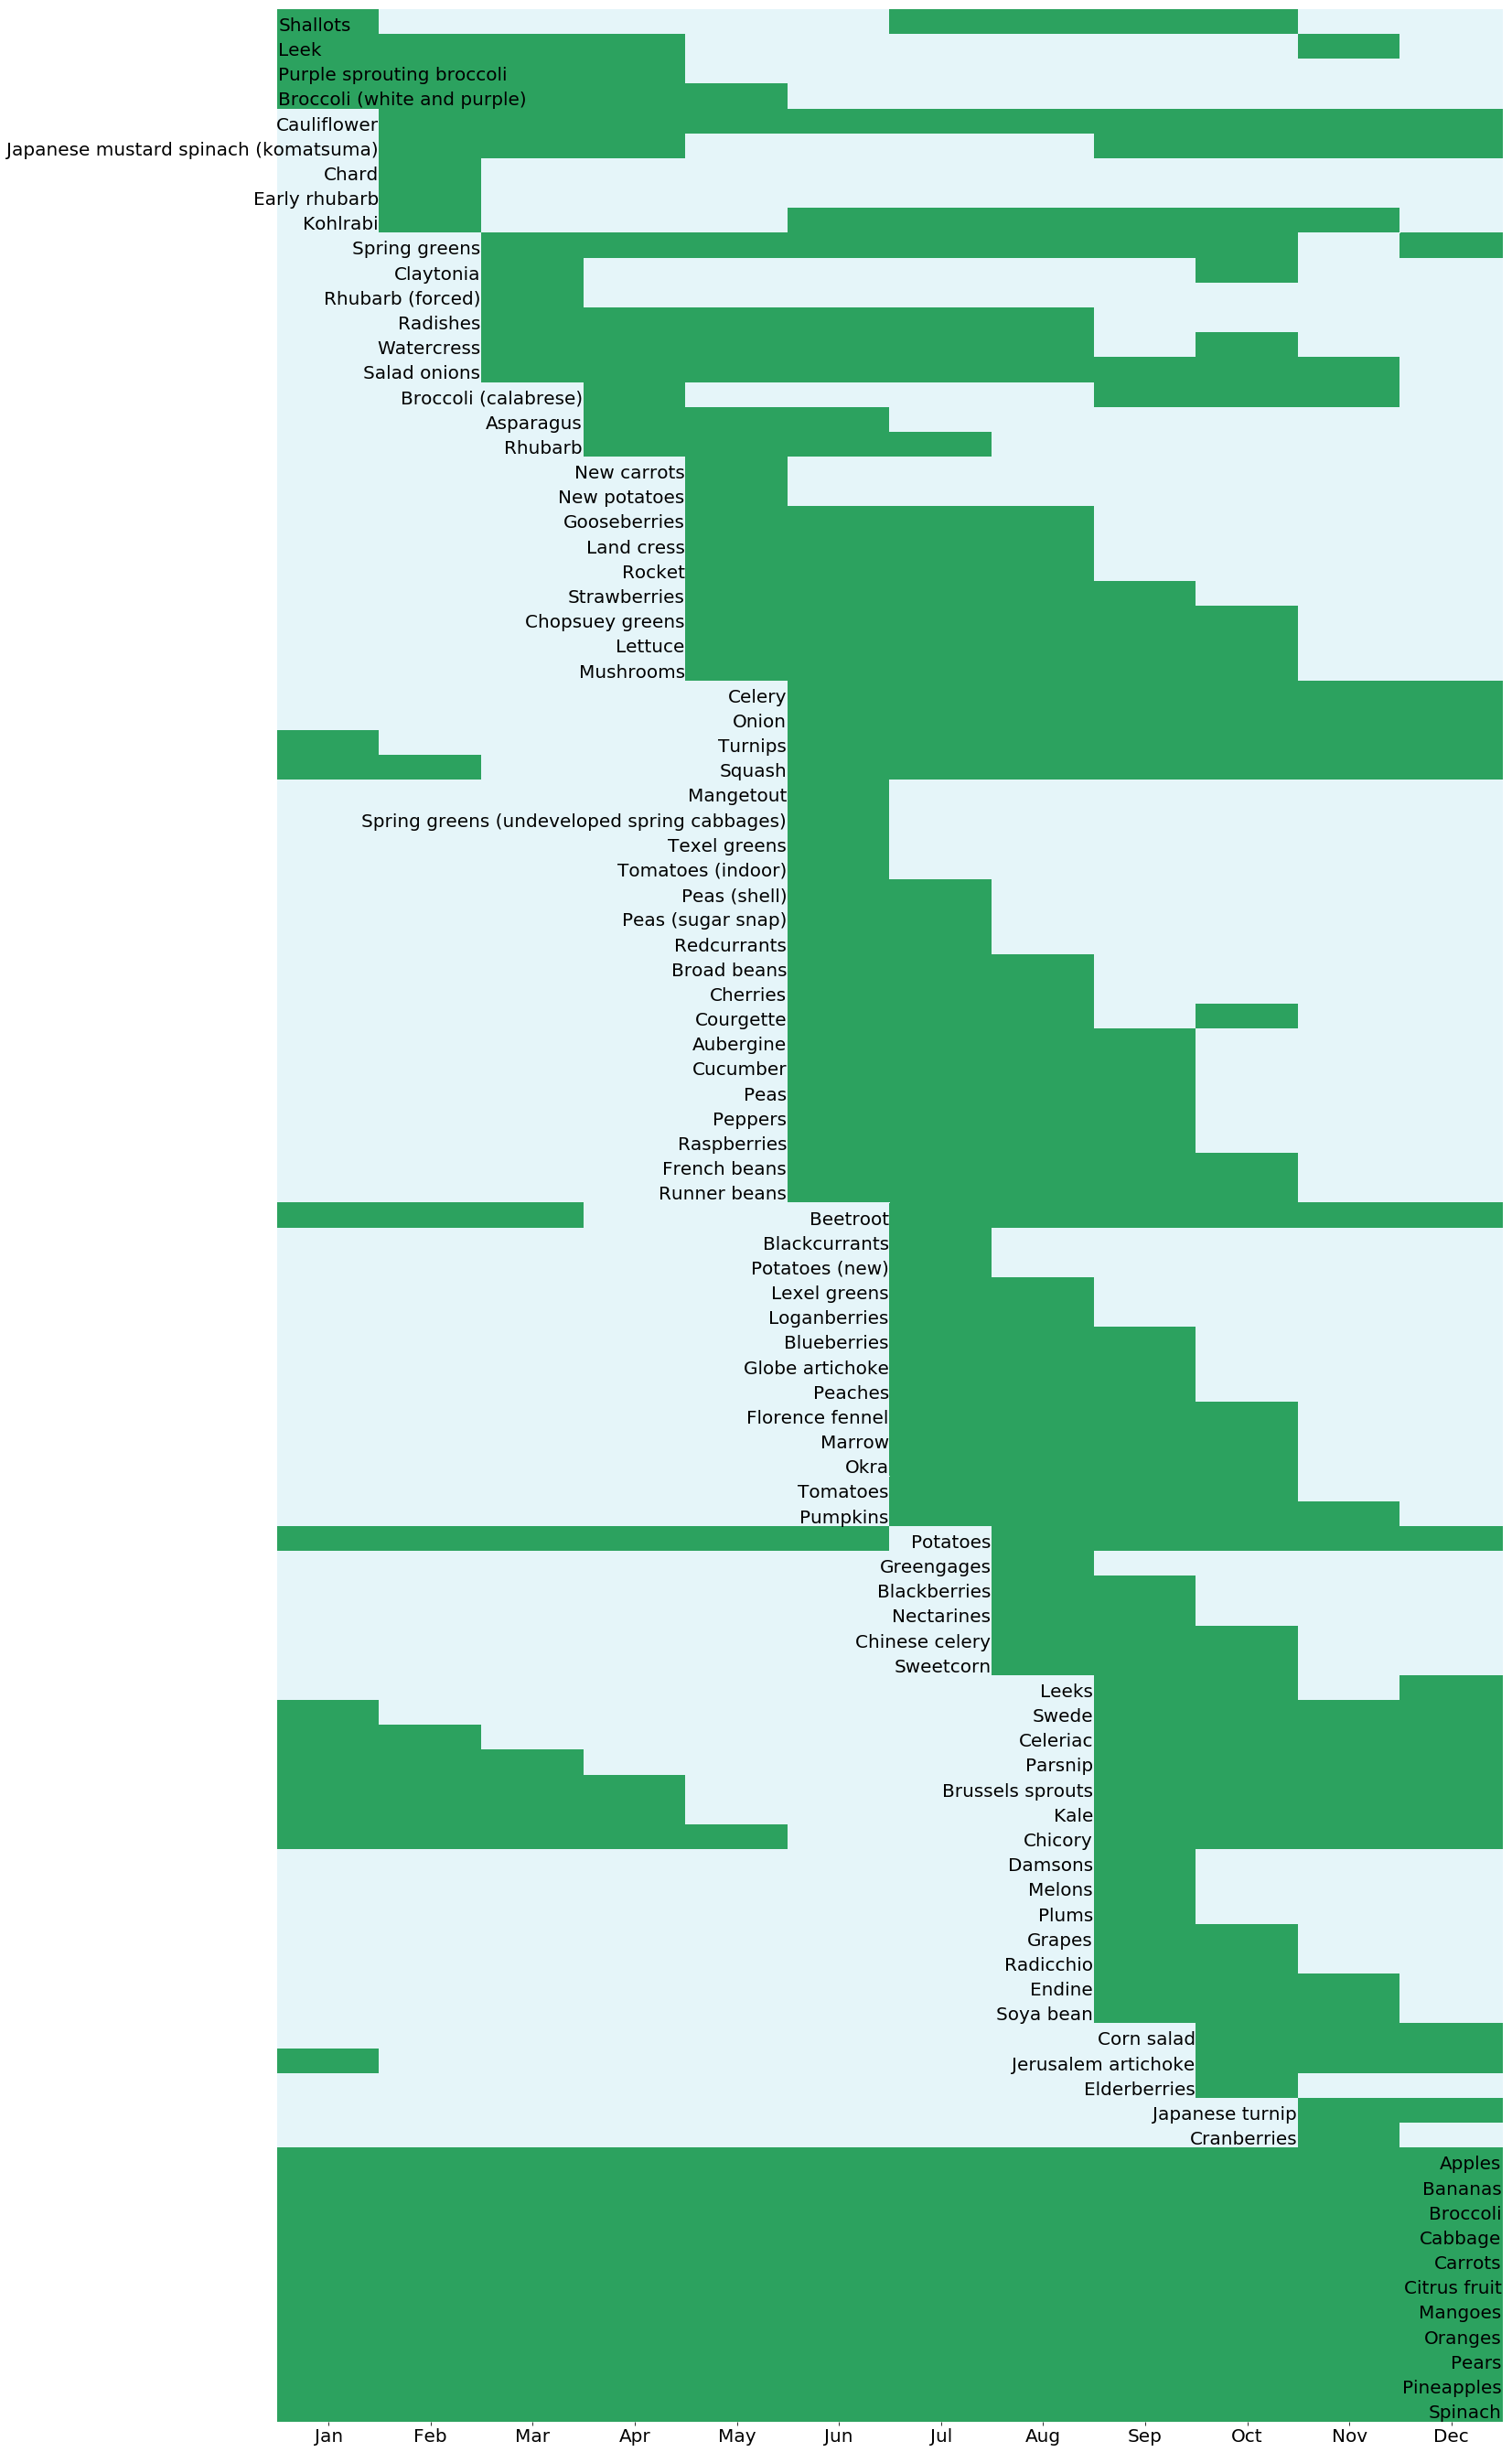

In [6]:
veg_season_idx = seasonality_start_ends(veg_seasonality_hbab).reset_index()
veg_season_idx = veg_season_idx.sort_values(
    by=['start', 'coming_in', 'end', 'index'],
    na_position='last')
veg_seasonality_hbab = veg_seasonality_hbab.iloc[veg_season_idx.index]
ax = plot_seasonality_chart(veg_seasonality_hbab,
                            veg_season_idx,
                            colors,
                            legend=False)
plt.show()

In [7]:
# save cleaned data to excel for editing

def colour_for_excel(val):
    return 'background-color: {}'.format('#2ca25f' if val == 1 else '#e5f5f9')

(veg_seasonality_hbab.style
                     .applymap(colour_for_excel)
                     .to_excel('howbadarebananas_seasonality.xlsx',
                               engine='openpyxl'))